# Урок 6. Нейросети в обработке текста.
## Домашнее задание
1. Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?


In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Скачаем датасет с каггла:

In [2]:
! kaggle datasets download arkhoshghalb/twitter-sentiment-analysis-hatred-speech

  0% 0.00/1.89M [00:00<?, ?B/s]
100% 1.89M/1.89M [00:00<00:00, 195MB/s]


In [3]:
! unzip twitter-sentiment-analysis-hatred-speech.zip

Archive:  twitter-sentiment-analysis-hatred-speech.zip
  inflating: test.csv                
  inflating: train.csv               


In [4]:
!pip install stop-words pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 4.5 MB/s 
     |████████████████████████████████| 8.2 MB 51.0 MB/s 
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=ac15142dca90ed7ad2e6916af00452e44becb901622a00163e29925b0e5acf2b
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


Скачаем библиотеку для лемматизации английских слов:

In [5]:
! pip install spacy
! spacy download en

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.0 MB 19.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


Установим необходимые библиотеки:

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
import spacy
from tqdm import tqdm 
tqdm.pandas()
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")
from nltk.probability import FreqDist
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
df = pd.read_csv("train.csv")

Посмотрим датасет:

In [8]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [9]:
df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

Распределение лейблов очень неравномерное.

Разобьем датасет, используя стратификацию:

In [10]:
df_train, df_test = train_test_split(df, test_size=0.3, shuffle=True, stratify=df['label'], random_state=42)

In [11]:
df_test['label'].value_counts()

0    8916
1     673
Name: label, dtype: int64

Подготовим функцию для обработки текста с лемматизацией:

In [12]:
sw = set(get_stop_words("english"))
puncts = set(punctuation)
nlp = spacy.load('en', disable=['parser', 'ner'])

def preprocess_text(txt):
  txt = str(txt)
  txt = "".join(c for c in txt if c not in puncts)
  txt = txt.lower()
  txt = re.sub("not\s", "not", txt)
  txt = re.sub("dont\s", "dont", txt)
  txt = re.sub("doesnt\s", "doesnt", txt)
  txt = re.sub("didnt\s", "didnt", txt)
  txt = re.sub("havent\s", "havent", txt)
  txt = re.sub("hasnt\s", "hasnt", txt)
  txt = nlp(txt)
  txt = [word.lemma_ for word in txt if word not in sw]
  return " ".join(txt)

In [13]:
df_train['tweet'].iloc[:1].values

array(['happy bihday to my brother man. needed this mixtape like we need boos. have a good one sach   @user '],
      dtype=object)

In [14]:
df_train['tweet'].iloc[:1].apply(preprocess_text).values

array(['happy bihday to -PRON- brother man need this mixtape like -PRON- need boo have a good one sach    user'],
      dtype=object)

Применим обработку текста с лемматизацией к трейну и тесту:

In [15]:
df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_test['tweet'] = df_test['tweet'].progress_apply(preprocess_text)

100%|██████████| 9589/9589 [00:27<00:00, 343.60it/s]


Составим корпус текстов:

In [16]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

Инициализируем функцию токенизации:

In [17]:
def text_to_sequence(text, maxlen, vocabulary):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

Инициализируем сеть:

In [18]:
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = F.sigmoid(output)
        return output

Инициализируем класс кастомного датасета:

In [18]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

Инициализируем функцию подготовки загрузчиков:

In [19]:
def get_loaders(max_words=2000, max_len=20):

    tokens = word_tokenize(train_corpus)
    tokens_filtered = [word for word in tokens if word.isalnum()]
    dist = FreqDist(tokens_filtered)
    tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]
    vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

    x_train = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df_train["tweet"]])
    x_test = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df_test["tweet"]])

    train_dataset = DataWrapper(x_train, df_train['label'].values)
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

    test_dataset = DataWrapper(x_test, df_test['label'].values)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
    return train_loader, test_loader

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Инициализируем функцию обучения модели:

In [21]:
def learn_net(model, epochs=20, th=0.5):
  model = model.to(device)
  model.train()
  
  train_loss_history = []
  test_loss_history = []


  for epoch in range(epochs):  
      running_loss, running_items, running_right = 0.0, 0.0, 0.0
      for i, data in enumerate(train_loader, 0):
          inputs, labels = data[0].to(device), data[1].to(device)
          
          # обнуляем градиент
          optimizer.zero_grad()
          outputs = model(inputs)
          
          loss = criterion(outputs, labels.float().view(-1, 1))
          loss.backward()
          optimizer.step()

          # подсчет ошибки на обучении
          running_loss += loss.item()
          running_items += len(labels)
          # подсчет метрики на обучении
          pred_labels = torch.squeeze((outputs > th).int())
          running_right += (labels == pred_labels).sum()
          
      # выводим статистику о процессе обучения
      model.eval()
      
      print(f'Epoch [{epoch + 1}/{epochs}]. ' \
              f'Step [{i + 1}/{len(train_loader)}]. ' \
              f'Loss: {running_loss/(i+1):.3f}. ' \
              f'Acc: {running_right / running_items:.3f}', end='. ')
      
      train_loss_history.append(running_loss/(i+1))
      running_loss, running_items, running_right = 0.0, 0.0, 0.0

          # выводим статистику на тестовых данных
      test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
      for j, data in enumerate(test_loader):
          test_labels = data[1].to(device)
          test_outputs = model(data[0].to(device))
          
          # подсчет ошибки на тесте
          test_loss += criterion(test_outputs, test_labels.float().view(-1, 1))
          # подсчет метрики на тесте
          test_running_total += len(data[1])
          pred_test_labels = torch.squeeze((test_outputs > th).int())
          test_running_right += (test_labels == pred_test_labels).sum()
      
      test_loss_history.append(test_loss.item()/(j+1))
      print(f'Test loss: {test_loss/(j+1):.3f}. Test acc: {test_running_right / test_running_total:.3f}')
      test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
      model.train()
          
  print('Training is finished!')
  return train_loss_history, test_loss_history

Проведем эксперимент - обучим сети для разного количества слов в словаре:

In [29]:
losses_train = []
losses_test = []
for i in [1000, 2000, 3000]:
  train_loader, test_loader = get_loaders(max_words=i)
  model = Net(vocab_size=i)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  criterion = nn.BCELoss()
  train_loss_history, test_loss_history = learn_net(model)
  losses_train.append(train_loss_history)
  losses_test.append(test_loss_history)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/20]. Step [44/44]. Loss: 0.238. Acc: 0.910. Test loss: 0.192. Test acc: 0.930
Epoch [2/20]. Step [44/44]. Loss: 0.161. Acc: 0.939. Test loss: 0.175. Test acc: 0.944
Epoch [3/20]. Step [44/44]. Loss: 0.123. Acc: 0.954. Test loss: 0.154. Test acc: 0.947
Epoch [4/20]. Step [44/44]. Loss: 0.097. Acc: 0.963. Test loss: 0.164. Test acc: 0.941
Epoch [5/20]. Step [44/44]. Loss: 0.074. Acc: 0.972. Test loss: 0.211. Test acc: 0.939
Epoch [6/20]. Step [44/44]. Loss: 0.060. Acc: 0.978. Test loss: 0.243. Test acc: 0.912
Epoch [7/20]. Step [44/44]. Loss: 0.049. Acc: 0.982. Test loss: 0.271. Test acc: 0.945
Epoch [8/20]. Step [44/44]. Loss: 0.033. Acc: 0.989. Test loss: 0.309. Test acc: 0.947
Epoch [9/20]. Step [44/44]. Loss: 0.026. Acc: 0.991. Test loss: 0.446. Test acc: 0.947
Epoch [10/20]. Step [44/44]. Loss: 0.025. Acc: 0.992. Test loss: 0.405. Test acc: 0.944
Epoch [11/20]. Step [44/44]. Loss: 0.026. Acc: 0.991. Test loss: 0.362. Test acc: 0.945
Epoch [12/20]. Step [44/44]. Loss: 0.021.

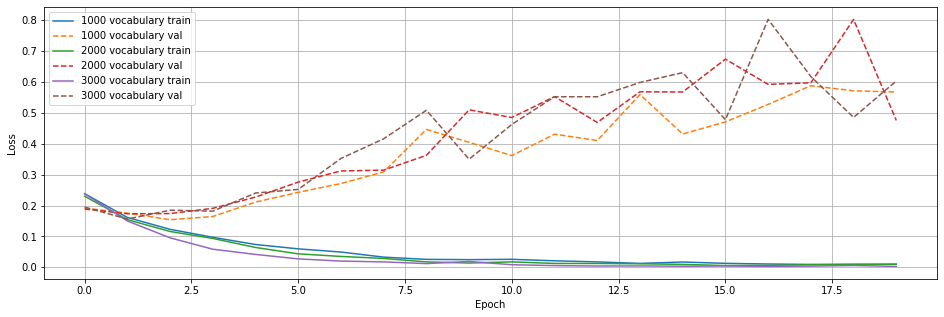

In [30]:
plt.figure(figsize = (16,5))
for i in range(3):
    plt.plot(losses_train[i],'-',label = f'{(i+1)*1000} vocabulary train')
    plt.plot(losses_test[i],'--',label = f'{(i+1)*1000} vocabulary val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show() 

Как видно, сеть жутко переобучается, но сеть с наименьшим словарем ведет себя чуть лучше остальных.

Попробуем сеть с дропаутами. Инициализируем ее:

In [34]:
class Net2(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(out_channel, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        self.dp1 = nn.Dropout(.4)
        self.dp2 = nn.Dropout(.4)
        self.dp3 = nn.Dropout(.4)
        self.dp4 = nn.Dropout(.4)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L 
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.dp4(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.dp1(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.dp2(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = self.dp3(output)
        output = F.sigmoid(output)
        return output

Обучим сеть с дропаутами:

In [38]:
train_loader, test_loader = get_loaders(max_words=1000)
model = Net2(vocab_size=1000)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()
train_loss_history, test_loss_history = learn_net(model)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/20]. Step [44/44]. Loss: 0.454. Acc: 0.924. Test loss: 0.335. Test acc: 0.930
Epoch [2/20]. Step [44/44]. Loss: 0.400. Acc: 0.930. Test loss: 0.257. Test acc: 0.930
Epoch [3/20]. Step [44/44]. Loss: 0.395. Acc: 0.930. Test loss: 0.250. Test acc: 0.930
Epoch [4/20]. Step [44/44]. Loss: 0.372. Acc: 0.931. Test loss: 0.184. Test acc: 0.930
Epoch [5/20]. Step [44/44]. Loss: 0.368. Acc: 0.934. Test loss: 0.241. Test acc: 0.945
Epoch [6/20]. Step [44/44]. Loss: 0.363. Acc: 0.937. Test loss: 0.206. Test acc: 0.946
Epoch [7/20]. Step [44/44]. Loss: 0.360. Acc: 0.939. Test loss: 0.209. Test acc: 0.940
Epoch [8/20]. Step [44/44]. Loss: 0.354. Acc: 0.937. Test loss: 0.182. Test acc: 0.946
Epoch [9/20]. Step [44/44]. Loss: 0.349. Acc: 0.940. Test loss: 0.183. Test acc: 0.947
Epoch [10/20]. Step [44/44]. Loss: 0.343. Acc: 0.941. Test loss: 0.183. Test acc: 0.948
Epoch [11/20]. Step [44/44]. Loss: 0.352. Acc: 0.940. Test loss: 0.195. Test acc: 0.947
Epoch [12/20]. Step [44/44]. Loss: 0.348.

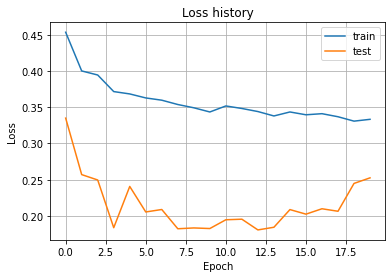

In [39]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

Как видно, сеть уже не так сильно переобучается, но после 9 эпохи лосс на тесте начинает расти.

Теперь попробуем разную длину последовательностей:

In [24]:
losses_train = []
losses_test = []
for i in [10, 15, 20]:
  train_loader, test_loader = get_loaders(max_words=1000, max_len=i)
  model = Net2(vocab_size=1000)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  criterion = nn.BCELoss()
  train_loss_history, test_loss_history = learn_net(model)
  losses_train.append(train_loss_history)
  losses_test.append(test_loss_history)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/20]. Step [44/44]. Loss: 0.438. Acc: 0.919. Test loss: 0.324. Test acc: 0.930
Epoch [2/20]. Step [44/44]. Loss: 0.396. Acc: 0.930. Test loss: 0.293. Test acc: 0.930
Epoch [3/20]. Step [44/44]. Loss: 0.380. Acc: 0.930. Test loss: 0.197. Test acc: 0.930
Epoch [4/20]. Step [44/44]. Loss: 0.376. Acc: 0.934. Test loss: 0.190. Test acc: 0.936
Epoch [5/20]. Step [44/44]. Loss: 0.370. Acc: 0.939. Test loss: 0.216. Test acc: 0.945
Epoch [6/20]. Step [44/44]. Loss: 0.365. Acc: 0.940. Test loss: 0.191. Test acc: 0.940
Epoch [7/20]. Step [44/44]. Loss: 0.360. Acc: 0.940. Test loss: 0.199. Test acc: 0.946
Epoch [8/20]. Step [44/44]. Loss: 0.357. Acc: 0.942. Test loss: 0.185. Test acc: 0.945
Epoch [9/20]. Step [44/44]. Loss: 0.353. Acc: 0.942. Test loss: 0.204. Test acc: 0.945
Epoch [10/20]. Step [44/44]. Loss: 0.348. Acc: 0.946. Test loss: 0.182. Test acc: 0.947
Epoch [11/20]. Step [44/44]. Loss: 0.353. Acc: 0.943. Test loss: 0.197. Test acc: 0.948
Epoch [12/20]. Step [44/44]. Loss: 0.345.

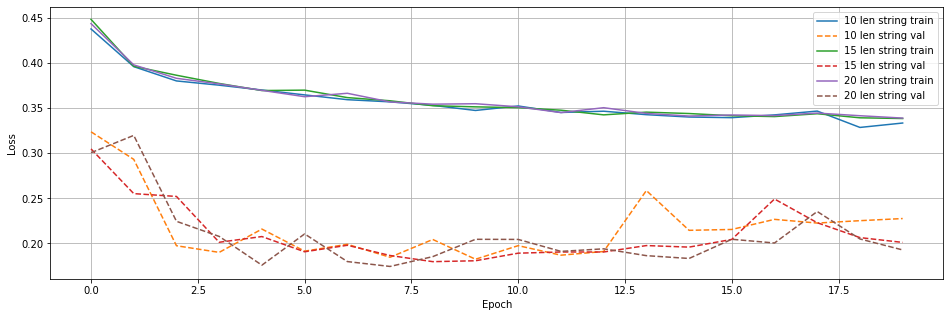

In [25]:
plt.figure(figsize = (16,5))
for i in range(3):
    plt.plot(losses_train[i],'-',label = f'{i * 5 + 10} len string train')
    plt.plot(losses_test[i],'--',label = f'{i * 5 + 10} len string val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show() 

Особо ничего не меняется в лоссе на тесте, но наиболее плавно ведет себя сеть с длиной последовательности 15.

Теперь попробуем разную длину эмбеддинга:

In [35]:
losses_train = []
losses_test = []
for i in [64, 128, 256]:
  train_loader, test_loader = get_loaders(max_words=1000, max_len=15)
  model = Net2(vocab_size=1000, embedding_dim=i)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  criterion = nn.BCELoss()
  train_loss_history, test_loss_history = learn_net(model)
  losses_train.append(train_loss_history)
  losses_test.append(test_loss_history)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/20]. Step [44/44]. Loss: 0.442. Acc: 0.929. Test loss: 0.328. Test acc: 0.930
Epoch [2/20]. Step [44/44]. Loss: 0.399. Acc: 0.930. Test loss: 0.251. Test acc: 0.930
Epoch [3/20]. Step [44/44]. Loss: 0.385. Acc: 0.931. Test loss: 0.257. Test acc: 0.936
Epoch [4/20]. Step [44/44]. Loss: 0.369. Acc: 0.937. Test loss: 0.187. Test acc: 0.940
Epoch [5/20]. Step [44/44]. Loss: 0.367. Acc: 0.937. Test loss: 0.199. Test acc: 0.939
Epoch [6/20]. Step [44/44]. Loss: 0.366. Acc: 0.940. Test loss: 0.216. Test acc: 0.941
Epoch [7/20]. Step [44/44]. Loss: 0.362. Acc: 0.942. Test loss: 0.184. Test acc: 0.947
Epoch [8/20]. Step [44/44]. Loss: 0.354. Acc: 0.943. Test loss: 0.185. Test acc: 0.945
Epoch [9/20]. Step [44/44]. Loss: 0.355. Acc: 0.942. Test loss: 0.180. Test acc: 0.945
Epoch [10/20]. Step [44/44]. Loss: 0.355. Acc: 0.944. Test loss: 0.188. Test acc: 0.947
Epoch [11/20]. Step [44/44]. Loss: 0.345. Acc: 0.945. Test loss: 0.189. Test acc: 0.947
Epoch [12/20]. Step [44/44]. Loss: 0.350.

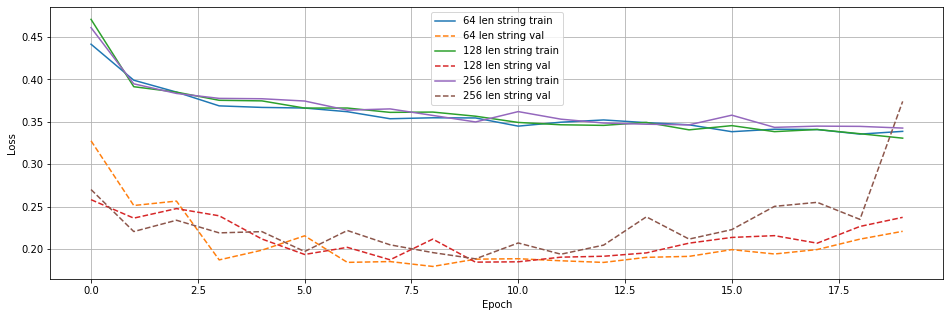

In [37]:
plt.figure(figsize = (16,5))
for i in range(3):
    plt.plot(losses_train[i],'-',label = f'{2**(6 + i)} len string train')
    plt.plot(losses_test[i],'--',label = f'{2**(6 + i)} len string val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show() 

По прежнему не особо сильно что-то изменилось, но при длине вектора эмбеддинга 64 вроде лучший лосс.

**Общие выводы:**


*   Accuracy на тесте доходит до 95%. Но тривиальное предсказание нуля при таком дизбалансе нам дает 92.8%
*   Никакой подбор параметров не дал особого уменьшения лосса на тесте, удалось лишь существенно сократить переобучение.





